In [277]:
import fastai
from fastai.tabular.all import *
import pandas as pd
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

warnings.filterwarnings('ignore')

# matplotlib.rcParams['figure.figsize'] = (10, 4) # default params for plot size

In [278]:
path_root = Path(r'C:\Users\Oleg\Google Drive\Projects\misc\house prices')
path_train = os.path.join(path_root, 'train.csv')
path_test = os.path.join(path_root, 'test.csv')

In [279]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

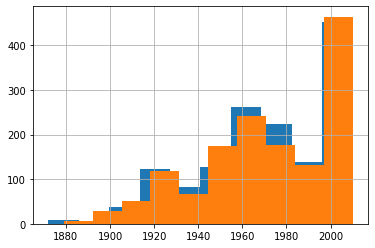

In [280]:
# compare distribution
# pd.dfFrame({'train_years':df_train['YearBuilt'], 'test_years':df_test['YearBuilt']}).hist(); # cool to plot 2 plots at once

df_train['YearBuilt'].hist(), df_test['YearBuilt'].hist(); # looks like same distribution (same as previous row but 1 plot)

In [281]:
df = pd.concat([df_train, df_test], 0)

In [282]:
# df.isnull().sum().sort_values(ascending=False).head(20) # checking missing

In [283]:
# PREPROCESS
df['SalePrice'] = df['SalePrice'].fillna(0)

# fireplace
df['FireplaceQu_yes'] = (~df['FireplaceQu'].isnull()).astype(int)
df['FireplaceQu'] = df['FireplaceQu'].fillna('Missing')
df['FireplaceQu'] = df['FireplaceQu'].map({'Missing':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

# garages
df['Garage_yes'] = (~df['GarageQual'].isnull()).astype(int)
df['GarageQual'] = df['GarageQual'].fillna('Missing')
df['GarageQual'] = df['GarageQual'].map({'Missing':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['GarageCars'] = df['GarageCars'].fillna(0)
df['GarageArea'] = df['GarageArea'].fillna(0)
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())

# basement
df['Bsmt_yes'] = (~df['BsmtUnfSF'].isnull()).astype(int)
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)
df['BsmtQual'] = df['BsmtQual'].fillna('Missing')
df['BsmtQual'] = df['BsmtQual'].map({'Missing':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

df['Fence_yes'] = (~df['Fence'].isnull()).astype(int)
df['Fence'] = df['Fence'].fillna('Missing')

df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0]) 
df.loc[df['Functional'] != 'Typ', 'Functional'] = 'Other'
df['KitchenQual'] = df['KitchenQual'].map({'Missing':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0]) 
df.loc[df['SaleType'] != 'WD', 'SaleType'] = 'Other'
df.loc[df['Electrical'] != 'SBrkr', 'Electrical'] = 'Other'
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])

df['ExterQual'] = df['ExterQual'].map({'Missing':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

# DROP
to_drop = ['BsmtFinSF1', 'BsmtFinSF2', 'MasVnrArea', 'Id', 'PoolQC', 'MiscFeature', 'Alley', 'BsmtUnfSF', 'BsmtHalfBath', 'BsmtFullBath', 'Utilities',
          'BsmtUnfSF', 'GarageType', 'GarageCond', 'GarageFinish', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType',
          'MiscVal', 'LowQualFinSF', '3SsnPorch', 'PoolArea', 'Condition1', 'Condition2', 'Street','RoofMatl', 'Heating', 'SaleCondition', 
           'BldgType', 'ExterCond', 'YrSold', 'KitchenAbvGr', 'LandContour', 'LandSlope', 'PavedDrive', 'Functional',
          '1stFlrSF', '2ndFlrSF', 'GarageYrBlt', 'YearRemodAdd', 'EnclosedPorch', 'ScreenPorch']

df.drop(to_drop, 1, inplace=True)

In [284]:
df.isnull().sum().max() # checking missing

0

In [285]:
#correlation matrix
# corrmat = df[cont_cols].corr()
# f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

## Assemble back

In [286]:
train = df.iloc[:df_train.shape[0], :].copy()
test = df.iloc[df_train.shape[0]:, :].copy()

In [287]:
train.shape, test.shape

((1460, 42), (1459, 42))

In [288]:
val = 40
cont_cols = [c for c in df.columns if df[c].nunique() > val]
cat_cols = [c for c in df.columns if df[c].nunique() <= val]

In [289]:
len(cont_cols), len(cat_cols)

(9, 33)

In [290]:
def fixer(feature, value, df1=train):
    return df1.drop(df1.loc[df1[feature] > value, feature].index, 0, inplace=True), plotter(feature)

def plotter(feature, df1=train, df2=test):
    fig, ax = plt.subplots(1, 2, figsize=(16,4))
    fig.suptitle(feature, fontsize=20)
    ax[0].set_title('x', fontsize=20)
    ax[1].set_title('x_test', fontsize=20)
    sns.boxplot(df1[feature], ax=ax[0])
    sns.boxplot(df2[feature], ax=ax[1]);

In [291]:
cont_cols

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'TotalBsmtSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'SalePrice']

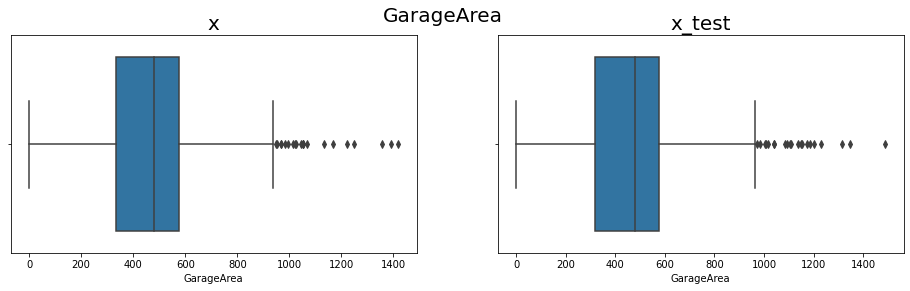

In [292]:
plotter('GarageArea')

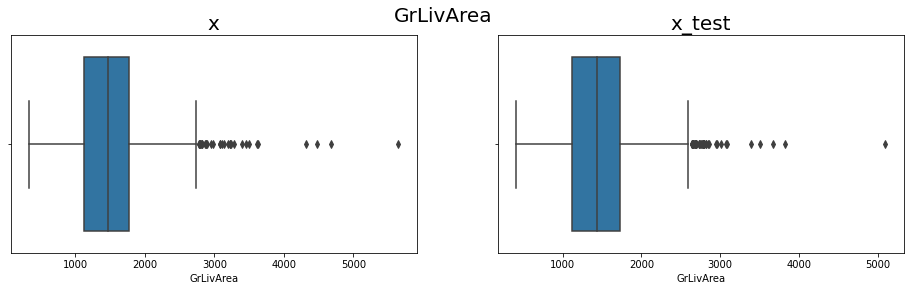

In [293]:
plotter('GrLivArea')

(None, None)

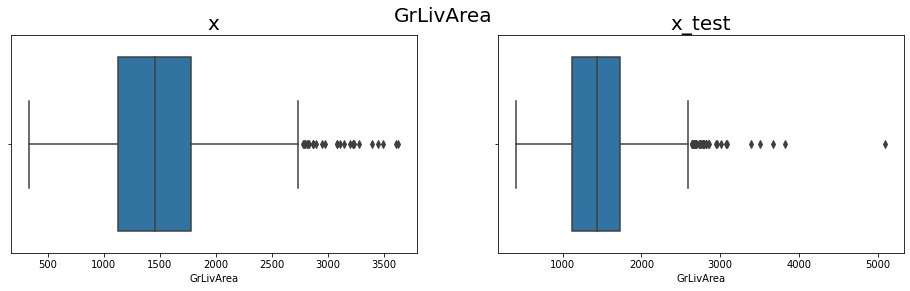

In [294]:
fixer('GrLivArea', 4000)

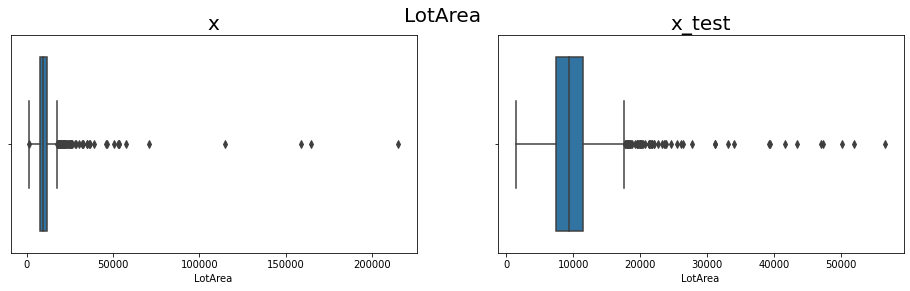

In [295]:
plotter('LotArea');

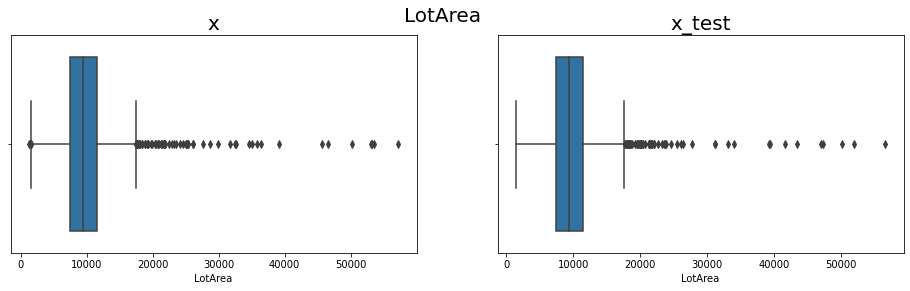

In [296]:
fixer('LotArea', 60000);

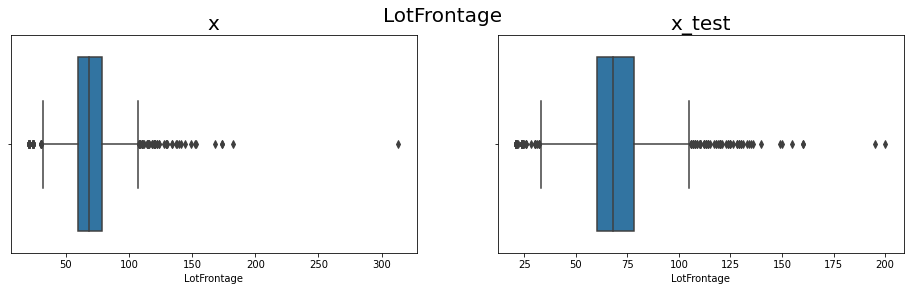

In [297]:
plotter('LotFrontage');

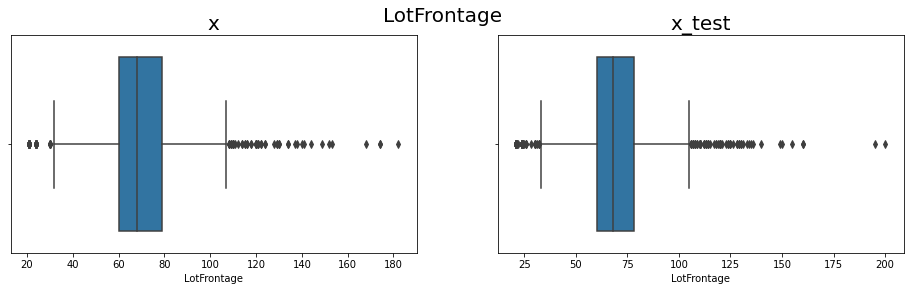

In [298]:
fixer('LotFrontage', 200);

In [299]:
# plotter('OpenPorchSF')

In [300]:
# plotter('TotalBsmtSF')

In [301]:
# plotter('WoodDeckSF')

In [302]:
# plotter('YearBuilt')

In [303]:
train.shape, test.shape

((1450, 42), (1459, 42))

In [304]:
df_imp = pd.concat([train, test], 0)
df_imp.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,WoodDeckSF,OpenPorchSF,Fence,MoSold,SaleType,SalePrice,FireplaceQu_yes,Garage_yes,Bsmt_yes,Fence_yes
0,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,...,0,61,Missing,2,WD,208500.0,0,1,1,0


In [305]:
for c in df_imp[cont_cols[:-1]]:
    df_imp[c] = np.log1p(df_imp[c])

df_imp.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,WoodDeckSF,OpenPorchSF,Fence,MoSold,SaleType,SalePrice,FireplaceQu_yes,Garage_yes,Bsmt_yes,Fence_yes
0,60,RL,4.189655,9.04204,Reg,Inside,CollgCr,2Story,7,5,...,0.0,4.127134,Missing,2,WD,208500.0,0,1,1,0


In [306]:
for c in cat_cols:
    df_imp[c] = df_imp[c].astype('category')

In [307]:
for c in cont_cols:
    df_imp[c] = df_imp[c].astype('float')

In [308]:
df_imp.shape

(2909, 42)

## Random Forest

In [309]:
# prepare data for rf
df_oh = pd.get_dummies(df_imp, drop_first=True)
df_oh['YearBuilt'] = df_oh['YearBuilt'].astype('float')
train = df_oh.loc[df_oh['SalePrice'] != 0].copy()
test = df_oh.loc[df_oh['SalePrice'] == 0].copy()

test.drop('SalePrice', 1, inplace=True)

In [310]:
train.shape, test.shape

((1450, 203), (1459, 202))

In [311]:
x = train.drop('SalePrice', 1).copy()
y = np.log(train['SalePrice']).copy() # take a log else values too big + skew. MUST EXP AFTER PREDICT

In [312]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [317]:
rf = RandomForestRegressor(n_jobs=-1,
                           n_estimators=100,
                           max_features=0.5,
                           oob_score=True,
                           random_state=42).fit(x_train, y_train)

In [318]:
# rf_cv = np.sqrt(np.mean(-cross_val_score(rf, x_train, y_train, cv=5, scoring='neg_mean_squared_error')))
# rf_cv

In [319]:
# eval on train overfits
rf.score(x_train, y_train)

0.9803099787414324

In [320]:
# eval on test
rf.score(x_test, y_test)

0.8664809033217797

In [321]:
# eval on oob (very similar to test. OOB = eval while training on samples that were not in train)
rf.oob_score_

0.8549808291771868

In [322]:
rf_preds = rf.predict(x_test)
print(f'rf rmse: {round(np.sqrt(mean_squared_error(np.exp(rf_preds), np.exp(y_test))))}')

rf real rmse: 24952


## XGBoost

In [323]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,
                             random_state = 1, nthread = -1)

# model_xgb = xgb.XGBRegressor(n_estimators=1000, random_state=1)

model_xgb.fit(x_train, y_train)

xgb_valid_preds = model_xgb.predict(x_test)
print(f'xgb rmse: {round(np.sqrt(mean_squared_error(np.exp(xgb_valid_preds), np.exp(y_test))))}')

xgb rmse: 22446


## fast ai nn

In [390]:
train_nn = df_imp.loc[df_imp['SalePrice'] != 0].copy()
train_nn['SalePrice'] = np.log1p(train_nn['SalePrice']) # log target

test_nn = df_imp.loc[df_imp['SalePrice'] == 0].copy()

test_nn.drop('SalePrice', 1, inplace=True)

dep_var = 'SalePrice'
cont_nn, cat_nn = cont_cat_split(train_nn, max_card=40, dep_var=dep_var)
splits = RandomSplitter(valid_pct=0.2)(range_of(train_nn))

In [391]:
train_nn.shape, test_nn.shape

((1450, 42), (1459, 41))

epoch,train_loss,valid_loss,time
0,146.596680,143.631424,00:00
1,141.234009,142.676727,00:00
2,134.852371,141.060135,00:00
3,127.453568,137.861603,00:00
4,118.424683,131.124573,00:00
5,107.107681,116.346886,00:00
6,94.621880,89.260468,00:00
7,84.966087,65.969177,00:00
8,78.487679,54.247646,00:00
9,71.562187,39.659710,00:00


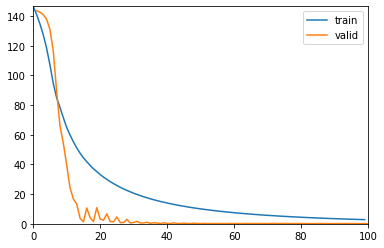

In [410]:
procs_nn = [Categorify, Normalize]
to_nn = TabularPandas(df=train_nn,
                      procs=procs_nn,
                      cat_names=cat_nn,
                      cont_names=cont_nn,
                      splits=splits,
                      y_names=dep_var)

dls = to_nn.dataloaders(bs=1024)

learn = tabular_learner(dls, n_out=1, loss_func=F.mse_loss)
# learn.lr_find()

learn.fit_one_cycle(30, slice(1e-3, 1e-1), cbs=[ShowGraphCallback()])
# learn.fit_one_cycle(50, slice(0.01, 0.1));

In [411]:
nn_valid_preds, nn_valid_targs = learn.get_preds()

nn_valid_preds = np.exp(nn_valid_preds)
nn_valid_targs = np.exp(nn_valid_targs)

np.sqrt(mean_squared_error(nn_valid_targs, nn_valid_preds))

In [412]:
dl = learn.dls.test_dl(test_nn, bs=1024)
preds, _ = learn.get_preds(dl=dl) # get prediction

In [413]:
nn_preds = np.exp(preds.flatten()).tolist()

## CV strategy

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard#Modelling

In [414]:
# prepare data for rf
df_oh = pd.get_dummies(df_imp, drop_first=True)
df_oh['YearBuilt'] = df_oh['YearBuilt'].astype('float')
train = df_oh.loc[df_oh['SalePrice'] != 0].copy()
test = df_oh.loc[df_oh['SalePrice'] == 0].copy()

y = train['SalePrice']
train.drop('SalePrice', 1, inplace=True)
test.drop('SalePrice', 1, inplace=True)

In [415]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Lasso regression

In [417]:
 lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state=42))

## Elastic Net Regression

In [418]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

## Kernel Ridge Regression

In [419]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

## Gradient Boosting Regression

In [420]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

## XGBoost

In [421]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =42, nthread = -1)

## LightGBM 

In [422]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

## Scores

In [423]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 27355.7255 (2247.8465)



In [424]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 27252.9741 (2187.0311)



In [425]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 26630.1339 (942.5508)



In [426]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

KeyboardInterrupt: 

In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

## Stacking models

In [656]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        
        return np.mean(predictions, axis=1) 

In [657]:
averaged_models = AveragingModels(models = (lasso, ENet, KRR, GBoost, model_xgb, model_lgb))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
#  Averaged base models score: 0.1271 (0.0126)

[22:03:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[22

In [662]:
use_models = [lasso, ENet, KRR, GBoost, model_xgb, model_lgb]
# use_models = [lasso, ENet]

preds = np.stack([(m.fit(train, y)).predict(test) for m in use_models])
    

[22:05:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [663]:
# model = lasso.fit(train, y)
# preds = model.predict(test)

In [664]:
preds.shape

(6, 1459)

In [667]:
final_preds = np.exp(np.mean(preds, axis=0))

In [668]:
final_preds

array([125123.58233713, 162768.07791504, 185359.91537082, ...,
       171244.29537167, 122370.98396376, 209456.53697799])

In [669]:
sub = pd.read_csv(os.path.join(path_root, 'sample_submission.csv'))
sub.SalePrice = final_preds

filename = 'submission.csv'
sub.to_csv(filename, index=False)